<a href="https://colab.research.google.com/github/etietopabraham/Numerical-ODE-Solver/blob/main/Numerical_ODE_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

y(x) = is the corrected value of y at each step using the explicit Euler method.

Δyk = is the change in y at each step, computed at h *f(x,y).

Y~ucm = is the uncorrected value for y at each step.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



In [2]:
class ODESolver:
    """
    A class to solve ordinary differential equations (ODEs) using various numerical methods.

    Attributes:
    - f: The function representing the ODE dy/dx = f(x, y)
    - x0, y0: Initial conditions
    - h: Step size for the numerical method
    - steps: Number of steps to perform
    - x_values, y_values: Lists to store the computed x and y values
    - delta_y_values: List to store the change in y at each step
    """

    def __init__(self, f, x0, y0, h, steps):
        """Initialize the ODESolver with the ODE function, initial conditions, step size, and number of steps."""
        self.f = f
        self.x0 = x0
        self.y0 = y0
        self.h = h
        self.steps = steps
        self.x_values = [x0]
        self.y_values = [y0]
        self.delta_y_values = [0]  # No change at the initial condition

    class Method:
        """
        Nested class to define different numerical methods for solving ODEs.
        """

        @staticmethod
        def euler(x, y, h, f):
            """Compute the next y value using the Euler method."""
            return y + h * f(x, y)

        @staticmethod
        def euler_cauchy(x, y, h, f):
            """Compute the next y value using the Euler-Cauchy method."""
            y_star = y + h * f(x, y)
            return y + (h / 2) * (f(x, y) + f(x + h, y_star))

        @staticmethod
        def implicit_euler_cauchy(x, y, h, f):
            """Compute the next y value using the Implicit Euler-Cauchy method (simplified for linear f)."""
            return y + (h / 2) * (f(x, y) + f(x + h, y + h * f(x, y)))

        @staticmethod
        def rk4(x, y, h, f):
            """Compute the next y value using the fourth-order Runge-Kutta method."""
            k1 = h * f(x, y)
            k2 = h * f(x + 0.5 * h, y + 0.5 * k1)
            k3 = h * f(x + 0.5 * h, y + 0.5 * k2)
            k4 = h * f(x + h, y + k3)
            return y + (k1 + 2*k2 + 2*k3 + k4) / 6

        @staticmethod
        def adams_bashforth_2(x, y, h, f, prev_f):
            """Compute the next y value using the 2-step Adams-Bashforth method."""
            return y + (h / 2) * (3 * f(x, y) - prev_f)

    def get_delta_y(self, x, y):
        """Compute the change in y at each step."""
        return self.h * self.f(x, y)

    def solve(self, method, prev_method=None):
        """
        Solve the ODE using the specified numerical method.

        Arguments:
        - method: A function from the Method class representing the numerical method to use.
        - prev_method: Optional method to compute initial values for multistep methods.
        """
        if method == self.Method.adams_bashforth_2 and prev_method:
            for _ in range(1):  # For 2-step Adams-Bashforth, we need one additional starting value
                delta_y = self.get_delta_y(self.x0, self.y0)
                self.y0 = prev_method(self.x0, self.y0, self.h, self.f)
                self.x0 += self.h
                self.x_values.append(self.x0)
                self.y_values.append(self.y0)
                self.delta_y_values.append(delta_y)

        for _ in range(self.steps - (1 if method == self.Method.adams_bashforth_2 else 0)):
            delta_y = self.get_delta_y(self.x0, self.y0)

            # Handle special case for Adams-Bashforth
            if method == self.Method.adams_bashforth_2:
                prev_f = self.f(self.x_values[-2], self.y_values[-2])
                self.y0 = method(self.x0, self.y0, self.h, self.f, prev_f)
            else:
                self.y0 = method(self.x0, self.y0, self.h, self.f)

            self.x0 += self.h
            self.x_values.append(self.x0)
            self.y_values.append(self.y0)
            self.delta_y_values.append(delta_y)

    def get_results(self):
        """Return the results as a dataframe."""
        return pd.DataFrame({
            'x': self.x_values,
            'y(x)': self.y_values,
            'Δyk': self.delta_y_values
        })


In [3]:
def main(method, prev_method=None):
    """
    Main function to use the ODESolver class to solve the differential equation dy/dx = (y + x)^2.

    Arguments:
    - method: A function from the ODESolver.Method class representing the numerical method to use.
    - prev_method: Optional method to compute initial values for multistep methods.

    Returns:
    - df: A DataFrame containing the x values, y(x) values, and Δyk values.
    """

    # Define the ODE function
    def f(x, y):
        """Function representing the ODE dy/dx = (y + x)^2."""
        return (y + x)**2

    # Initialize and solve the ODE using the specified method
    x0 = 0
    y0 = 0
    h = 0.1
    steps = int(0.5 / h)

    solver = ODESolver(f, x0, y0, h, steps)
    solver.solve(method, prev_method)
    df = solver.get_results()

    return df

# Testing the updated class and main function
df_adams_bashforth = main(ODESolver.Method.adams_bashforth_2, ODESolver.Method.rk4)
df_euler = main(ODESolver.Method.euler)
df_euler_cauchy = main(ODESolver.Method.euler_cauchy)
df_implicit_euler_cauchy = main(ODESolver.Method.implicit_euler_cauchy)
df_rk4 = main(ODESolver.Method.rk4)



In [4]:
# Define the exact solution
def exact_solution(x):
    return np.tan(x) - x

# Generate x values and compute the exact solution values
x_values = np.arange(0, 0.5 + 0.1, 0.1)  # x values from 0 to 0.5 with a step of 0.1
exact_y_values = exact_solution(x_values)

In [5]:
# Combine the results in one table
combined_df = pd.DataFrame({
    'x': x_values,
    'Exact Solution': exact_y_values,
    'Euler': df_euler['y(x)'],
    'Euler-Cauchy': df_euler_cauchy['y(x)'],
    'Implicit Euler-Cauchy': df_implicit_euler_cauchy['y(x)'],
    'RK4': df_rk4['y(x)'],
    'Adams-Bashforth': df_adams_bashforth['y(x)']
})

combined_df

,x,Exact Solution,Euler,Euler-Cauchy,Implicit Euler-Cauchy,RK4,Adams-Bashforth
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.1,0.000335,0.000000,0.000500,0.000500,0.000335,0.000335
2,0.2,0.002710,0.001000,0.003035,0.003035,0.002710,0.001845
3,0.3,0.009336,0.005040,0.009814,0.009814,0.009336,0.007452
4,0.4,0.022793,0.014345,0.023408,0.023408,0.022793,0.019594
5,0.5,0.046302,0.031513,0.047024,0.047024,0.046302,0.041277


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(combined_df, *['x'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(combined_df, *['Exact Solution'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(combined_df, *['Euler'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(combined_df, *['Euler-Cauchy'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(combined_df, *['x'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(combined_df, *['Exact Solution'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(combined_df, *['Euler'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(combined_df, *['Euler-Cauchy'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(combined_df, *[[['x', 'Exact Solution'], ['Exact Solution', 'Euler'], ['Euler', 'Euler-Cauchy'], ['Euler-Cauchy', 'Implicit Euler-Cauchy']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(combined_df, *['x', 'count()', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(combined_df, *['Exact Solution', 'count()', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(combined_df, *['Euler', 'count()', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(combined_df, *['Euler-Cauchy', 'count()', None], **{})
chart

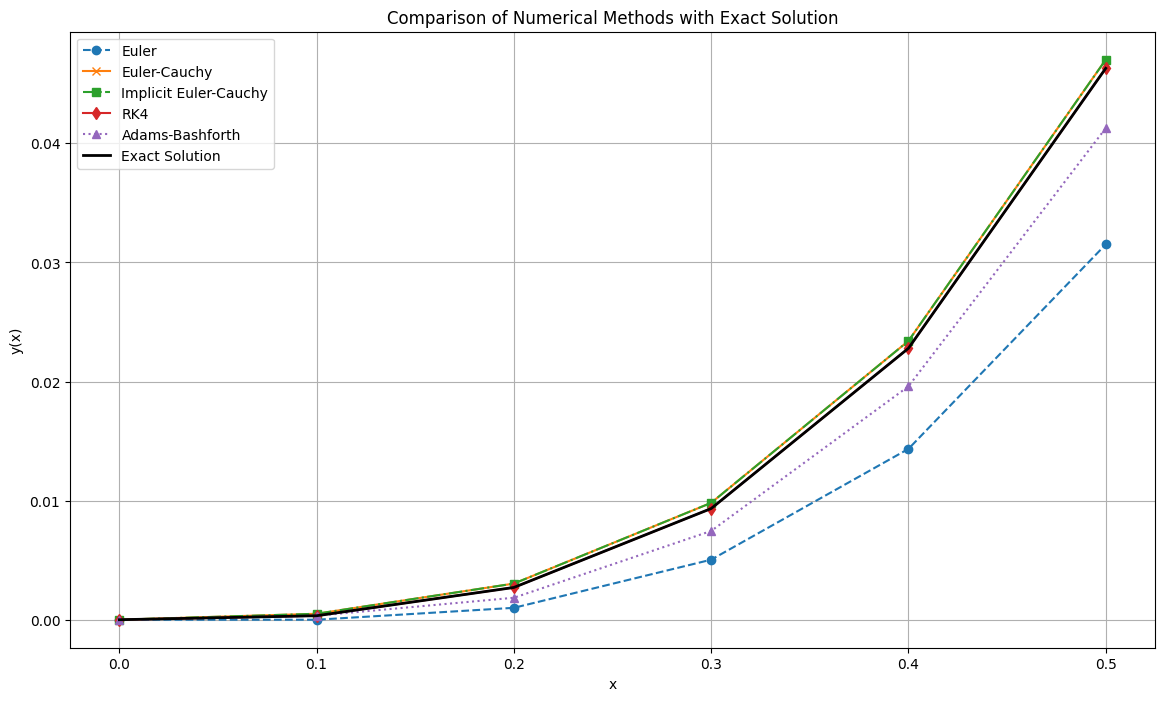

In [6]:
# Plot the results for all methods and the exact solution
plt.figure(figsize=(14, 8))

# Numerical methods
plt.plot(df_euler['x'], df_euler['y(x)'], label='Euler', marker='o', linestyle='--')
plt.plot(df_euler_cauchy['x'], df_euler_cauchy['y(x)'], label='Euler-Cauchy', marker='x', linestyle='-')
plt.plot(df_implicit_euler_cauchy['x'], df_implicit_euler_cauchy['y(x)'], label='Implicit Euler-Cauchy', marker='s', linestyle='-.')
plt.plot(df_rk4['x'], df_rk4['y(x)'], label='RK4', marker='d', linestyle='-')
plt.plot(df_adams_bashforth['x'], df_adams_bashforth['y(x)'], label='Adams-Bashforth', marker='^', linestyle=':')

# Exact solution
plt.plot(x_values, exact_y_values, label='Exact Solution', color='black', linewidth=2)

plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Comparison of Numerical Methods with Exact Solution')
plt.legend()
plt.grid(True)
plt.show()


# Application

Modeling task: fish harvest model

Consider there’s a fish population of size P which dynamics is described by

Three factors:

1. Linear growth over time
2. Constant harvest rate
3. Seasonal growth rate fluctuations

Formulate the model and analyze the solution behavior.

Given the problem statement, we have a differential equation of the form: dP/dt =(kcost)P(1-P)-h


In [7]:
def main_fish_simulation(k=0.2, h=0.05, P0=0.5, t0=0, h_step=1/12, total_steps=120, method=ODESolver.Method.rk4):
    """
    Main function to run the fish population dynamics simulation.
    This function organizes and executes the test simulation using the existing ODESolver class.

    Parameters:
    - k (float): Coefficient for seasonal growth rate fluctuations.
    - h (float): Constant harvest rate.
    - P0 (float): Initial fish population at time t0.
    - t0 (float): Initial time.
    - h_step (float): Step size for the numerical method.
    - total_steps (int): Number of steps to perform in the numerical method.
    - method (function): Numerical method to use for solving the ODE. Should be a method from ODESolver.Method.
    """

    # 1. Define the Differential Equation Function for Fish Population
    def fish_population(t, P):
        """Differential equation representing fish population dynamics."""
        return (k * np.cos(t)) * P * (1 - P) - h

    # 2. Initialize and Run the ODESolver
    solver = ODESolver(fish_population, t0, P0, h_step, total_steps)
    solver.solve(method)  # Using specified method for the simulation

    # 3. Retrieve and Print the Results
    df_results = solver.get_results()
    return df_results


In [12]:
# Call the main function to run the simulation
main_fish_simulation(k=0.2, h=0.1, P0=0.5, t0=0, h_step=1/12, total_steps=120, method=ODESolver.Method.rk4)

,x,y(x),Δyk
0,0.000000,0.500000,0.000000
1,0.083333,0.495828,-0.004167
2,0.166667,0.491627,-0.004181
3,0.250000,0.487368,-0.004226
4,0.333333,0.483020,-0.004299
...,...,...,...
116,9.666667,-0.411799,0.001270
117,9.750000,-0.410847,0.001074
118,9.833333,-0.410175,0.000821
119,9.916667,-0.409837,0.000514


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_30, *['x'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_31, *['y(x)'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_32, *['Δyk'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_33, *['x'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_34, *['y(x)'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_35, *['Δyk'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_36, *[[['x', 'y(x)'], ['y(x)', 'Δyk']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_37, *['x', 'y(x)', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_38, *['x', 'Δyk', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_39, *['x', 'count()', None], **{})
chart